## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import gc
import warnings
from itertools import combinations
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 100)

# Color palette for visualizations
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'success': '#C73E1D',
    'neutral': '#3B3B3B'
}

print("✅ Libraries imported")


✅ Libraries imported


## 2. Configuration

In [2]:
# Configuration
CONFIG = {
    'n_splits': 5,
    'purge_days': 5,
    'xgb_estimators': 5000,
    'lgb_estimators': 5000,
    'early_stopping': 200,
}

print("✅ Configuration set")


✅ Configuration set


## 3. Data Loading

In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory: {start_mem:.1f}MB → {end_mem:.1f}MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)')
    return df


In [4]:

# Load data
print("Loading training data...")
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
df = reduce_mem_usage(df)


# # RAPID MODE (comment out for full training)
# n_dates = df['date_id'].nunique()
# cutoff_date = int(n_dates * 0.05)
# print(f"RAPID MODE: Using first {cutoff_date} dates only.")
# df = df[df['date_id'] < cutoff_date].reset_index(drop=True)



print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date_id'].min()} to {df['date_id'].max()}")
print(f"Stocks: {df['stock_id'].nunique()}")
print(f"Time buckets per day: {df['seconds_in_bucket'].nunique()}")

Loading training data...
Memory: 679.4MB → 304.7MB (55.1% reduction)

Dataset shape: (5237980, 17)
Date range: 0 to 480
Stocks: 200
Time buckets per day: 55


## 4. Estimate Stock Weights from Data

In [5]:
def estimate_stock_weights(df):

    print("Estimating stock weights from data...")
    
    # Calculate average matched_size per stock (proxy for market cap)
    stock_stats = df.groupby('stock_id').agg({
        'matched_size': 'mean',
        'bid_size': 'mean',
        'ask_size': 'mean',
        'wap': 'mean'
    })
    
    # Estimate weight as proportion of total matched_size
    total_matched = stock_stats['matched_size'].sum()
    stock_stats['estimated_weight'] = stock_stats['matched_size'] / total_matched
    
    # Normalize to sum to 1
    stock_stats['estimated_weight'] = stock_stats['estimated_weight'] / stock_stats['estimated_weight'].sum()
    
    # Identify lead stocks (top 10 by weight)
    lead_stocks = stock_stats.nlargest(10, 'estimated_weight').index.tolist()
    
    # Create weight dictionary
    weight_dict = stock_stats['estimated_weight'].to_dict()
    
    print(f"  Total stocks: {len(weight_dict)}")
    print(f"  Lead stocks (top 10 by weight): {lead_stocks}")
    print(f"  Top stock weight: {stock_stats['estimated_weight'].max():.4f}")
    print(f"  Min stock weight: {stock_stats['estimated_weight'].min():.6f}")
    
    return weight_dict, lead_stocks, stock_stats


In [6]:
STOCK_WEIGHTS, LEAD_STOCKS, stock_weight_stats = estimate_stock_weights(df)

Estimating stock weights from data...
  Total stocks: 200
  Lead stocks (top 10 by weight): [112, 45, 168, 191, 41, 175, 179, 84, 142, 95]
  Top stock weight: 0.0996
  Min stock weight: 0.000073


## 5. Exploratory Data Analysis & Visualizations

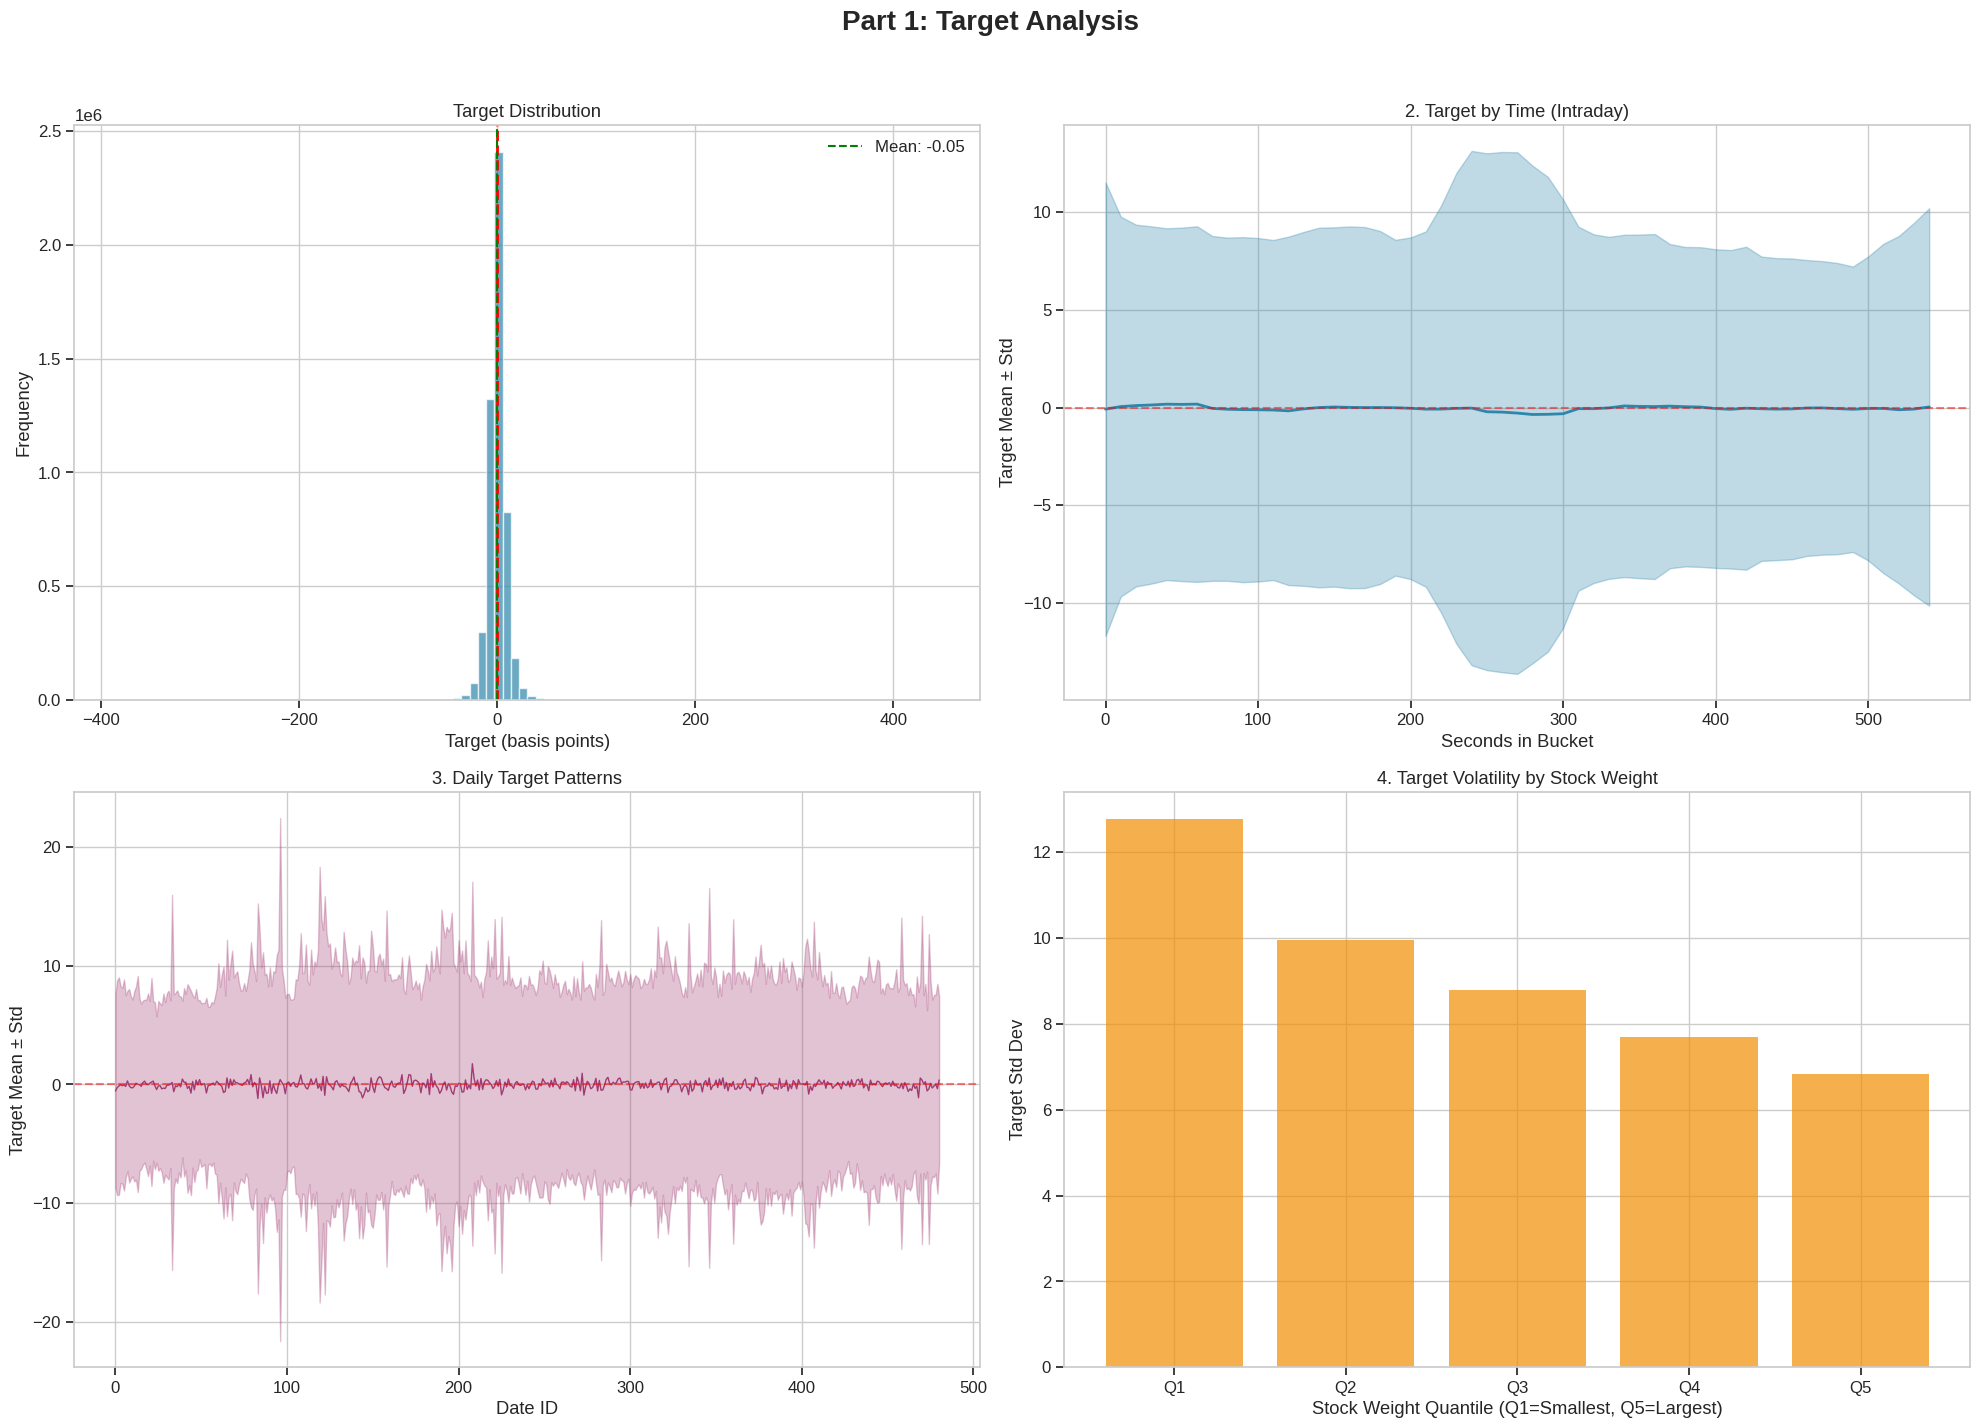

In [7]:
def plot_target_analysis(df, stock_weights):

    sns.set_context("notebook", font_scale=1.1)
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Part 1: Target Analysis', fontsize=20, fontweight='bold', y=1.02)

    # 1. Target Distribution (Scatter Plot)
    ax = axes[0, 0]
    target_clean = df['target'].dropna()
    ax.hist(target_clean, bins=100, color=COLORS['primary'], alpha=0.7, edgecolor='white')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=target_clean.mean(), color='green', linestyle='--', label=f'Mean: {target_clean.mean():.2f}')
    ax.set_xlabel('Target (basis points)')
    ax.set_ylabel('Frequency')
    ax.set_title('Target Distribution')
    ax.legend()

    # 2. Target by Time (Intraday)
    ax = axes[0, 1]
    target_by_time = df.groupby('seconds_in_bucket')['target'].agg(['mean', 'std'])
    ax.fill_between(target_by_time.index, 
                    target_by_time['mean'] - target_by_time['std'],
                    target_by_time['mean'] + target_by_time['std'],
                    alpha=0.3, color=COLORS['primary'])
    ax.plot(target_by_time.index, target_by_time['mean'], color=COLORS['primary'], linewidth=2)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Seconds in Bucket')
    ax.set_ylabel('Target Mean ± Std')
    ax.set_title('2. Target by Time (Intraday)')

    # 3. Daily Target Patterns
    ax = axes[1, 0]
    daily_stats = df.groupby('date_id')['target'].agg(['mean', 'std'])
    ax.fill_between(daily_stats.index, daily_stats['mean'] - daily_stats['std'],
                    daily_stats['mean'] + daily_stats['std'], alpha=0.3, color=COLORS['secondary'])
    ax.plot(daily_stats.index, daily_stats['mean'], color=COLORS['secondary'], linewidth=1)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Date ID')
    ax.set_ylabel('Target Mean ± Std')
    ax.set_title('3. Daily Target Patterns')

    # 4. Target Volatility by Stock Weight
    ax = axes[1, 1]
    df_temp = df.copy()
    df_temp['stock_weight'] = df_temp['stock_id'].map(stock_weights)
    
    # Create weight bins
    weight_percentiles = df_temp['stock_weight'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values
    weight_percentiles = np.unique(weight_percentiles)
    
    if len(weight_percentiles) >= 2:
        df_temp['weight_bin'] = pd.cut(df_temp['stock_weight'], 
                                        bins=weight_percentiles, 
                                        labels=[f'Q{i+1}' for i in range(len(weight_percentiles)-1)],
                                        include_lowest=True)
        target_by_weight = df_temp.groupby('weight_bin', observed=True)['target'].std()
        
        bars = ax.bar(range(len(target_by_weight)), target_by_weight.values, color=COLORS['accent'], alpha=0.7)
        ax.set_xticks(range(len(target_by_weight)))
        ax.set_xticklabels(target_by_weight.index)
        
    ax.set_ylabel('Target Std Dev')
    ax.set_xlabel('Stock Weight Quantile (Q1=Smallest, Q5=Largest)')
    ax.set_title('4. Target Volatility by Stock Weight')
    del df_temp

    plt.tight_layout()
    plt.show()

# Run Part 1
plot_target_analysis(df, STOCK_WEIGHTS)

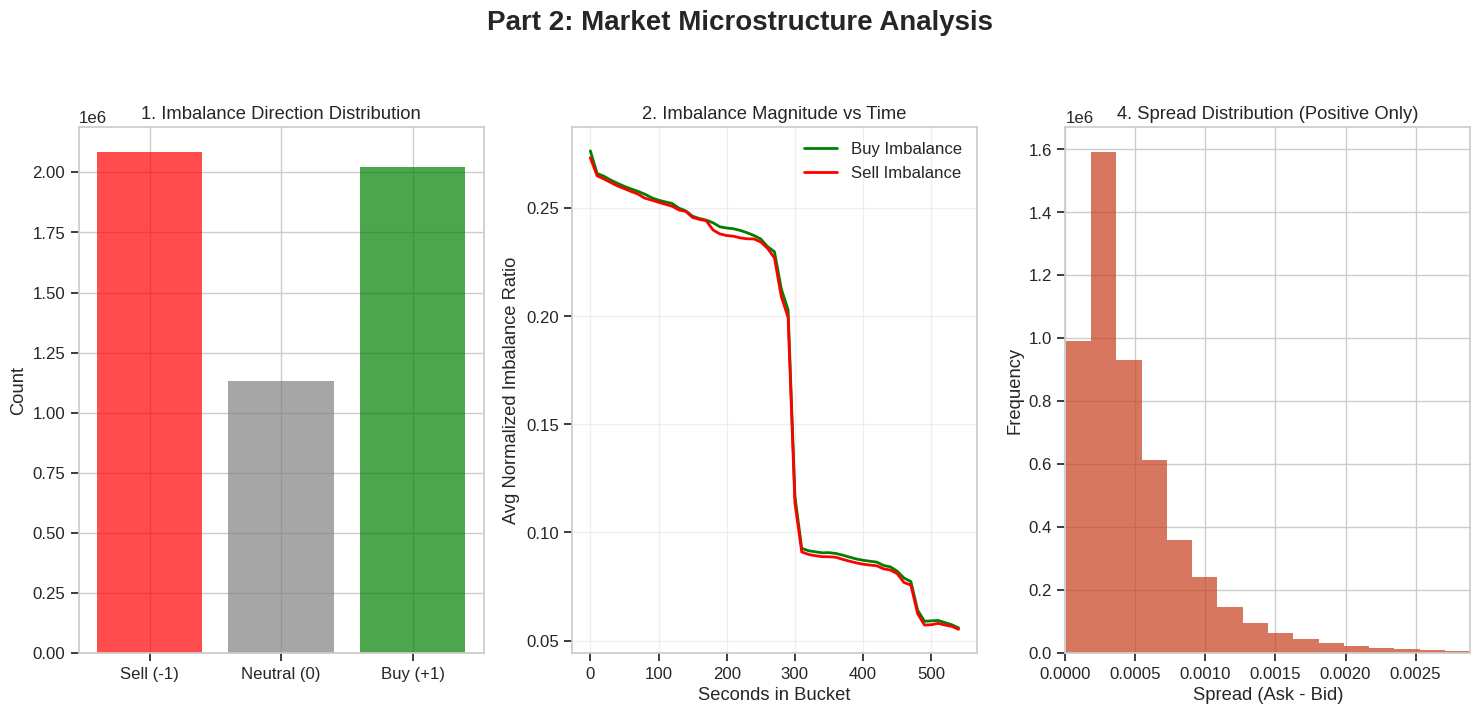

In [8]:
def plot_microstructure_analysis(df):

    sns.set_context("notebook", font_scale=1.1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    fig.suptitle('Part 2: Market Microstructure Analysis', fontsize=20, fontweight='bold', y=1.02)

    # 1. Imbalance Direction Distribution
    ax = axes[0]
    flag_counts = df['imbalance_buy_sell_flag'].value_counts().sort_index()
    colors_flag = ['red', 'gray', 'green']
    flag_indices = [-1, 0, 1]
    flag_values = [flag_counts.get(i, 0) for i in flag_indices]
    
    bars = ax.bar(flag_indices, flag_values, color=colors_flag, alpha=0.7)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels(['Sell (-1)', 'Neutral (0)', 'Buy (+1)'])
    ax.set_ylabel('Count')
    ax.set_title('1. Imbalance Direction Distribution')
    
    # 2. Normalized Imbalance Amount per Second
    ax = axes[1]
    df_imb = df.copy()
    # Normalize: imbalance / (imbalance + matched)
    df_imb['norm_imbalance'] = df_imb['imbalance_size'] / (df_imb['imbalance_size'] + df_imb['matched_size'] + 1e-6)
    
    # Group by Second AND Flag
    imb_by_sec = df_imb.groupby(['seconds_in_bucket', 'imbalance_buy_sell_flag'])['norm_imbalance'].mean().unstack()
    
    if 1 in imb_by_sec.columns:
        ax.plot(imb_by_sec.index, imb_by_sec[1], color='green', label='Buy Imbalance', linewidth=2)
    if -1 in imb_by_sec.columns:
        ax.plot(imb_by_sec.index, imb_by_sec[-1], color='red', label='Sell Imbalance', linewidth=2)
        
    ax.set_xlabel('Seconds in Bucket')
    ax.set_ylabel('Avg Normalized Imbalance Ratio')
    ax.set_title('2. Imbalance Magnitude vs Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---------------------------------------------------------

    # 3. Spread Distribution
    ax = axes[2]
    spread = df['ask_price'] - df['bid_price']
    spread_clean = spread[spread > 0].dropna()
    
    ax.hist(spread_clean, bins=100, color=COLORS['success'], alpha=0.7)
    ax.set_xlabel('Spread (Ask - Bid)')
    ax.set_ylabel('Frequency')
    ax.set_title('4. Spread Distribution (Positive Only)')
    ax.set_xlim(0, spread_clean.quantile(0.99))

    plt.tight_layout()
    plt.show()

# Run Part 2
plot_microstructure_analysis(df)

## 6. Stock Analysis & Clustering

In [9]:
def create_stock_profiles(df):

    print("Creating stock profiles...")
    
    profiles = df.groupby('stock_id').agg({
        # Price characteristics
        'wap': ['mean', 'std', 'min', 'max'],
        'bid_price': ['mean', 'std'],
        'ask_price': ['mean', 'std'],
        
        # Size characteristics
        'matched_size': ['mean', 'median', 'std'],
        'imbalance_size': ['mean', 'median', 'std'],
        'bid_size': ['mean', 'std'],
        'ask_size': ['mean', 'std'],
        
        # Target characteristics
        'target': ['mean', 'std', 'skew', lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)],
        
        # Imbalance direction
        'imbalance_buy_sell_flag': ['mean', 'std'],
    })
    
    profiles.columns = ['_'.join(col).strip() for col in profiles.columns]
    profiles = profiles.rename(columns={
        'target_<lambda_0>': 'target_q05',
        'target_<lambda_1>': 'target_q95'
    })
    
    # Add estimated weight
    profiles['estimated_weight'] = profiles.index.map(STOCK_WEIGHTS)
    
    # Add derived features
    profiles['wap_volatility'] = profiles['wap_std'] / (profiles['wap_mean'] + 1e-6)
    profiles['size_ratio'] = profiles['matched_size_mean'] / (profiles['imbalance_size_mean'] + 1e-6)
    profiles['spread_mean'] = profiles['ask_price_mean'] - profiles['bid_price_mean']
    profiles['target_range'] = profiles['target_q95'] - profiles['target_q05']
    
    # Check for lead stocks
    profiles['is_lead'] = profiles.index.isin(LEAD_STOCKS)
    
    return profiles


In [10]:
stock_profiles = create_stock_profiles(df)
print(f"Stock profiles shape: {stock_profiles.shape}")
stock_profiles.head()

Creating stock profiles...
Stock profiles shape: (200, 31)


,wap_mean,wap_std,wap_min,wap_max,bid_price_mean,bid_price_std,ask_price_mean,ask_price_std,matched_size_mean,matched_size_median,matched_size_std,imbalance_size_mean,imbalance_size_median,imbalance_size_std,bid_size_mean,bid_size_std,ask_size_mean,ask_size_std,target_mean,target_std,target_skew,target_q05,target_q95,imbalance_buy_sell_flag_mean,imbalance_buy_sell_flag_std,estimated_weight,wap_volatility,size_ratio,spread_mean,target_range,is_lead
stock_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.999842,0.001678,0.991243,1.009295,0.999735,0.001675,0.999954,0.001679,25754976.0,21065270.00,2.104866e+07,4.210672e+06,2.054860e+06,8.321268e+06,36045.937500,75318.384942,38356.347656,57668.534384,-0.261008,6.054234,-0.434009,-9.833038,8.939505,-0.155396,0.890933,0.002870,0.001678,6.116596,0.000219,18.772542,False
1,0.999929,0.002797,0.986747,1.016822,0.999480,0.002795,1.000392,0.002793,4222393.0,2768589.25,1.269290e+07,5.185133e+05,1.615905e+05,9.908059e+05,22565.736328,33339.741636,23091.037109,33105.166940,-0.119887,11.585558,-0.093806,-18.600225,18.570423,-0.032319,0.803461,0.000471,0.002798,8.143269,0.000912,37.170649,False
2,1.000145,0.002677,0.967298,1.021742,0.999697,0.002670,1.000608,0.002663,9895372.0,3980604.50,5.605824e+07,1.866116e+06,3.204967e+05,1.612834e+07,23600.347656,35444.210118,25819.679688,40230.444159,0.025008,10.979600,-0.648965,-16.750097,16.746283,0.046985,0.827912,0.001103,0.002676,5.302656,0.000911,33.496380,False
3,0.999977,0.001451,0.993659,1.012680,0.999872,0.001450,1.000091,0.001453,69959512.0,59605880.00,5.006637e+07,9.331594e+06,5.447338e+06,1.334086e+07,32339.316406,45832.987755,35430.386719,48042.782730,-0.137963,5.268300,-0.135992,-8.530021,7.900000,-0.064109,0.943743,0.007796,0.001451,7.497059,0.000219,16.430020,False
4,0.999863,0.001859,0.990960,1.009175,0.999728,0.001856,1.000002,0.001861,27326114.0,22604526.00,2.279876e+07,3.809995e+06,2.005156e+06,5.641951e+06,28348.287109,42141.152591,29114.623047,38529.121984,-0.223907,5.927556,-0.104974,-9.679794,9.119511,-0.076923,0.904707,0.003045,0.001859,7.172218,0.000274,18.799305,False


In [11]:
def cluster_stocks(profiles, n_clusters=12):

    print(f"Clustering stocks into {n_clusters} groups...")
    
    # Select features for clustering
    cluster_features = [
        'wap_mean', 'wap_volatility', 
        'matched_size_mean', 'imbalance_size_mean',
        'target_std', 'target_range',
        'estimated_weight', 'spread_mean'
    ]
    
    # Prepare data
    X_cluster = profiles[cluster_features].fillna(0)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    profiles['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze clusters
    cluster_summary = profiles.groupby('cluster').agg({
        'wap_mean': 'mean',
        'wap_volatility': 'mean',
        'target_std': 'mean',
        'estimated_weight': ['mean', 'sum', 'count'],
        'is_lead': 'sum'
    })
    
    return profiles, cluster_summary, scaler

Finding optimal cluster count...


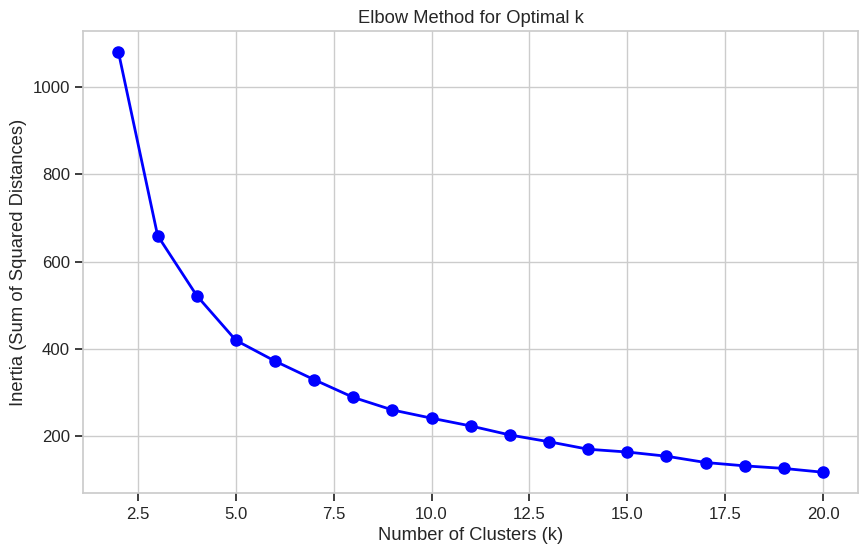

In [12]:
def find_optimal_clusters(profiles, max_k=20):
    print("Finding optimal cluster count...")
    
    cluster_features = [
        'wap_mean', 'wap_volatility', 
        'matched_size_mean', 'imbalance_size_mean',
        'target_std', 'target_range',
        'estimated_weight', 'spread_mean'
    ]
    X = profiles[cluster_features].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)
    
    inertias = []
    
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    return inertias

inertias = find_optimal_clusters(stock_profiles)

In [13]:
stock_profiles, cluster_summary, cluster_scaler = cluster_stocks(stock_profiles, 9)
print("\nCluster Summary:")
print(cluster_summary)

Clustering stocks into 9 groups...

Cluster Summary:
         wap_mean wap_volatility target_std estimated_weight                  \
             mean           mean       mean             mean       sum count   
cluster                                                                        
0        0.999964       0.003112  12.944739         0.000972  0.017502    18   
1        0.999904       0.001793   6.669456         0.002681  0.158207    59   
2        1.000002       0.001948   4.838176         0.094339  0.188677     2   
3        0.999997       0.002258   8.487371         0.002276  0.120634    53   
4        1.000022       0.002359   6.611719         0.038122  0.228730     6   
5        1.000310       0.004726  20.037970         0.000378  0.001135     3   
6        1.000081       0.002911  10.563931         0.002060  0.059743    29   
7        0.999959       0.001964   6.267460         0.011383  0.216272    19   
8        1.000203       0.003953  15.954281         0.000827  0.009

In [14]:
def plot_cluster_analysis(profiles, cluster_summary):

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Stock Cluster Analysis', fontsize=18, fontweight='bold')
    
    n_clusters = profiles['cluster'].nunique()
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # 1. Cluster sizes
    ax = axes[0, 0]
    cluster_sizes = profiles['cluster'].value_counts().sort_index()
    bars = ax.bar(cluster_sizes.index, cluster_sizes.values, color=colors)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Stocks')
    ax.set_title('Stocks per Cluster')
    for bar, val in zip(bars, cluster_sizes.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. WAP Volatility vs Target Std by cluster
    ax = axes[0, 1]
    for cluster in range(n_clusters):
        mask = profiles['cluster'] == cluster
        ax.scatter(profiles.loc[mask, 'wap_volatility'], 
                   profiles.loc[mask, 'target_std'],
                   c=[colors[cluster]], label=f'C{cluster}', s=80, alpha=0.7)
    ax.set_xlabel('WAP Volatility')
    ax.set_ylabel('Target Std Dev')
    ax.set_title('Volatility Characteristics by Cluster')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    
    # 3. Estimated weight by cluster
    ax = axes[0, 2]
    weight_by_cluster = profiles.groupby('cluster')['estimated_weight'].sum().sort_values(ascending=False)
    ax.bar(range(len(weight_by_cluster)), weight_by_cluster.values, 
           color=[colors[i] for i in weight_by_cluster.index])
    ax.set_xticks(range(len(weight_by_cluster)))
    ax.set_xticklabels([f'C{i}' for i in weight_by_cluster.index])
    ax.set_ylabel('Total Estimated Weight')
    ax.set_title('Weight Concentration by Cluster')
    
    # 4. Cluster characteristics heatmap
    ax = axes[1, 0]
    char_cols = ['wap_volatility', 'target_std', 'estimated_weight', 'matched_size_mean', 'spread_mean']
    cluster_chars = profiles.groupby('cluster')[char_cols].mean()
    # Normalize for visualization
    cluster_chars_norm = (cluster_chars - cluster_chars.min()) / (cluster_chars.max() - cluster_chars.min() + 1e-6)
    
    im = ax.imshow(cluster_chars_norm.T, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(range(n_clusters))
    ax.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax.set_yticks(range(len(char_cols)))
    ax.set_yticklabels(char_cols)
    ax.set_title('Normalized Cluster Characteristics')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 5. Lead stocks distribution
    ax = axes[1, 1]
    lead_by_cluster = profiles[profiles['is_lead']].groupby('cluster').size()
    all_clusters = pd.Series(0, index=range(n_clusters))
    lead_by_cluster = all_clusters.add(lead_by_cluster, fill_value=0)
    ax.bar(lead_by_cluster.index, lead_by_cluster.values, color=colors)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Lead Stocks')
    ax.set_title('Lead Stock Distribution')
    
    # 6. Target statistics by cluster
    ax = axes[1, 2]
    target_by_cluster = profiles.groupby('cluster')['target_std'].mean().sort_values(ascending=False)
    ax.barh(range(len(target_by_cluster)), target_by_cluster.values, 
            color=[colors[i] for i in target_by_cluster.index])
    ax.set_yticks(range(len(target_by_cluster)))
    ax.set_yticklabels([f'Cluster {i}' for i in target_by_cluster.index])
    ax.set_xlabel('Average Target Std Dev')
    ax.set_title('Cluster Volatility Ranking')
    
    plt.tight_layout()
    plt.show()


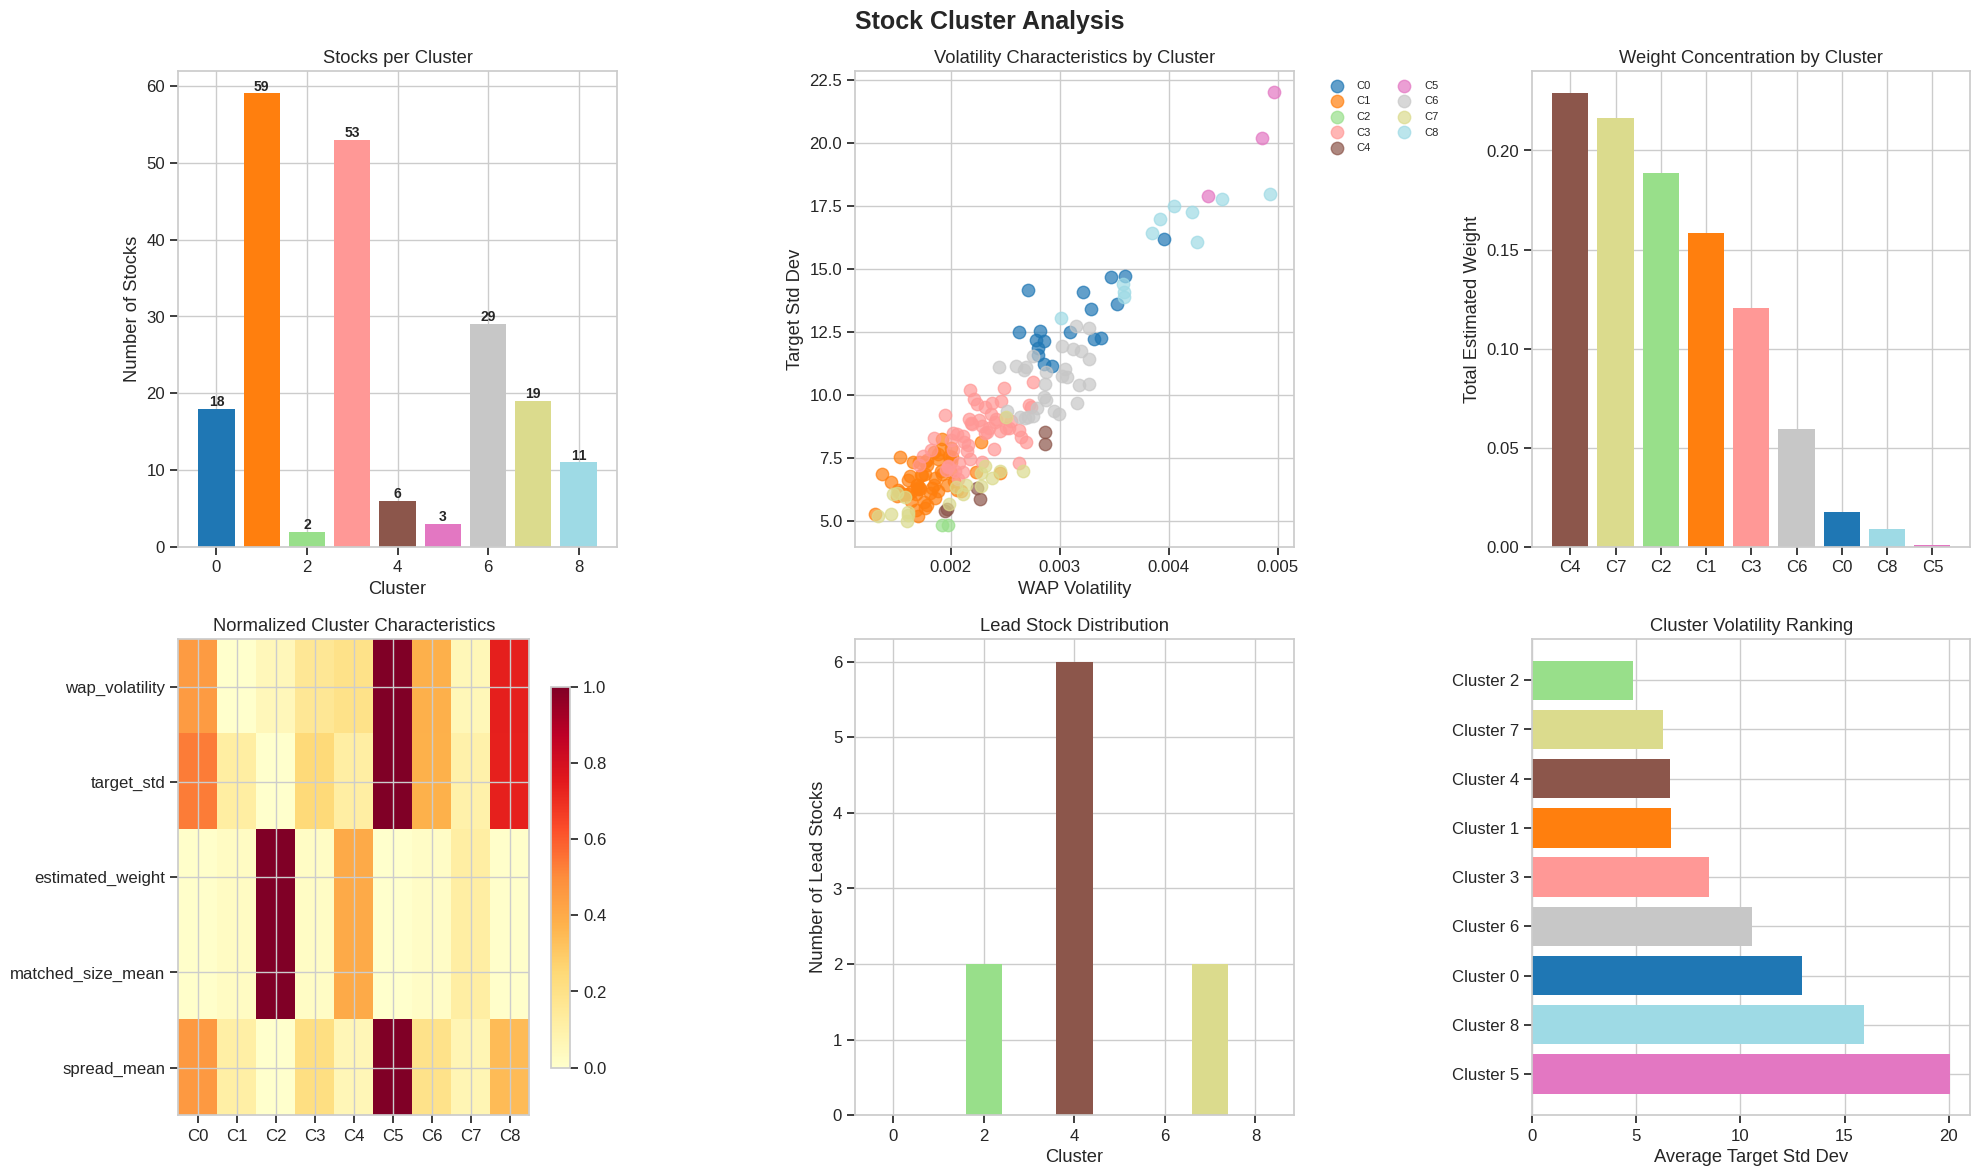

In [15]:
plot_cluster_analysis(stock_profiles, cluster_summary)


## 7. Feature Engineering

In [16]:
def impute_missing(df):
    df = df.copy()
    
    cols = ['imbalance_size', 'reference_price', 'matched_size', 'wap', 'bid_price', 'ask_price']
    df[cols] = df.groupby(['stock_id', 'date_id'])[cols].ffill().bfill()
    
    df['far_price_null'] = df['far_price'].isna().astype(np.int8)
    df['near_price_null'] = df['near_price'].isna().astype(np.int8)
    df['far_price'] = df['far_price'].fillna(df['reference_price'])
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    
    return df


def create_revealed_targets(df):

    print("Creating revealed targets...")
    
    revealed = df[['date_id', 'seconds_in_bucket', 'stock_id', 'target']].copy()
    revealed = revealed.rename(columns={'target': 'revealed_target'})
    revealed['date_id'] = revealed['date_id'] + 1
    
    return revealed



def create_features(df, stock_profiles, stock_weights, lead_stocks, revealed_targets=None):
    print("Creating features...")
    
    df = impute_missing(df)
    df = df.sort_values(['stock_id', 'date_id', 'seconds_in_bucket']).reset_index(drop=True)
    
    # ================================================================
    # BASIC FEATURES
    # ================================================================
    print("  Basic features...")
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['spread'] = df['ask_price'] - df['bid_price']
    df['spread_pct'] = df['spread'] / (df['wap'] + 1e-6)
    df['volume'] = df['bid_size'] + df['ask_size']
    
    # Imbalance features
    df['liquidity_imbalance'] = (df['bid_size'] - df['ask_size']) / (df['volume'] + 1e-6)
    df['size_imbalance'] = df['bid_size'] / (df['ask_size'] + 1e-6)
    df['matched_imbalance'] = (df['imbalance_size'] - df['matched_size']) / (df['matched_size'] + df['imbalance_size'] + 1e-6)
    df['signed_imbalance'] = df['imbalance_size'] * df['imbalance_buy_sell_flag']
    
    # Price comparisons
    prices = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    for p1, p2 in combinations(prices, 2):
        df[f'{p1}_{p2}_imb'] = (df[p1] - df[p2]) / (df[p1] + df[p2] + 1e-6)
    
    # Time features
    df['seconds'] = df['seconds_in_bucket'] % 60
    df['minute'] = df['seconds_in_bucket'] // 60
    df['time_pct'] = df['seconds_in_bucket'] / 600
    df['time_to_close'] = 600 - df['seconds_in_bucket']
    df['is_early'] = (df['seconds_in_bucket'] < 180).astype(np.int8)
    df['is_late'] = (df['seconds_in_bucket'] >= 420).astype(np.int8)
    
    # ================================================================
    # STOCK WEIGHT FEATURES
    # ================================================================
    print("  Stock weight features...")
    df['stock_weight'] = df['stock_id'].map(stock_weights).fillna(0).astype(np.float32)
    df['is_lead_stock'] = df['stock_id'].isin(lead_stocks).astype(np.int8)
    
    # ================================================================
    # SHIFT/LAG FEATURES
    # ================================================================
    print("  Lag features...")
    g = df.groupby(['stock_id', 'date_id'])
    
    for window in [1, 2, 3, 5, 10]:
        df[f'wap_shift_{window}'] = g['wap'].shift(window)
        df[f'imbalance_shift_{window}'] = g['imbalance_size'].shift(window)
        df[f'flag_shift_{window}'] = g['imbalance_buy_sell_flag'].shift(window)
        
        df[f'wap_ret_{window}'] = g['wap'].pct_change(window)
        df[f'imbalance_ret_{window}'] = g['imbalance_size'].pct_change(window)
        
        df[f'spread_diff_{window}'] = g['spread'].diff(window)
        df[f'volume_diff_{window}'] = g['volume'].diff(window)
    
    # ================================================================
    # CROSS-SECTIONAL FEATURES (MARKET-LEVEL)
    # ================================================================
    print("  Cross-sectional features...")
    ts = df.groupby(['date_id', 'seconds_in_bucket'])
    
    # Weighted index WAP
    df['weighted_wap'] = df['wap'] * df['stock_weight']
    df['index_wap'] = df.groupby(['date_id', 'seconds_in_bucket'])['weighted_wap'].transform('sum')
    
    # Simple market averages
    df['market_wap'] = ts['wap'].transform('mean')
    df['market_imbalance'] = ts['signed_imbalance'].transform('mean')
    df['market_flag'] = ts['imbalance_buy_sell_flag'].transform('mean')
    
    # Performance vs market
    df['perf_vs_market'] = 10000 * (df['wap'] - df['market_wap'])
    df['perf_vs_index'] = 10000 * (df['wap'] - df['index_wap'])
    
    # Cross-sectional ranks
    df['wap_rank'] = ts['wap'].rank(pct=True)
    df['imbalance_rank'] = ts['signed_imbalance'].rank(pct=True)
    
    # Total imbalance normalization
    total_imb = ts['imbalance_size'].transform('sum')
    df['imbalance_share'] = df['signed_imbalance'] / (total_imb + 1e-6)
    
    # ================================================================
    # INDEX RETURNS (WEIGHTED)
    # ================================================================
    print("  Index return features...")
    for window in [1, 2, 3, 5]:
        wap_change = df[f'wap_ret_{window}'].fillna(0)
        df[f'weighted_change_{window}'] = df['stock_weight'] * (wap_change + 1)
        df[f'index_ret_{window}'] = df.groupby(['date_id', 'seconds_in_bucket'])[f'weighted_change_{window}'].transform('sum')
        
        # Stock return vs index return
        stock_ret = df['wap'] / (df['wap'] - wap_change + 1e-6) - 1
        df[f'rel_perf_{window}'] = 10000 * (stock_ret - df[f'index_ret_{window}'])
        
        del df[f'weighted_change_{window}']
    
    # ================================================================
    # INFERRED PRICE FROM TICK SIZE
    # ================================================================
    print("  Inferred price features...")
    df['price_move'] = g['bid_price'].diff().abs()
    df.loc[df['price_move'] == 0, 'price_move'] = np.nan
    
    df['tick_size'] = g['price_move'].transform(
        lambda x: x.rolling(55, min_periods=1).min()
    )
    df['inferred_price'] = 0.01 / (df['tick_size'] + 1e-9)
    df['inferred_price'] = df['inferred_price'].clip(upper=1000)
    
    # Inferred volumes
    df['inferred_bid_vol'] = df['bid_size'] / (df['inferred_price'] + 1e-6)
    df['inferred_ask_vol'] = df['ask_size'] / (df['inferred_price'] + 1e-6)
    df['inferred_imb_vol'] = df['imbalance_size'] / (df['inferred_price'] + 1e-6)
    
    del df['price_move']
    
    # ================================================================
    # VOLATILITY FEATURES
    # ================================================================
    print("  Volatility features...")
    df['wap_vol_10'] = g['wap_ret_1'].transform(
        lambda x: x.rolling(10, min_periods=1).std()
    )
    
    # ================================================================
    # STOCK PROFILE FEATURES
    # ================================================================
    print("  Stock profile features...")
    profile_cols = ['cluster', 'wap_volatility', 'target_std', 'target_mean', 'estimated_weight']
    for col in profile_cols:
        if col in stock_profiles.columns:
            df[f'stock_{col}'] = df['stock_id'].map(stock_profiles[col].to_dict())
    
    # ================================================================
    # REVEALED TARGET FEATURES
    # ================================================================
    # NEW (fixed) - create a fresh groupby AFTER the merge
    if revealed_targets is not None:
        print("  Revealed target features...")
        df = df.merge(
            revealed_targets[['date_id', 'seconds_in_bucket', 'stock_id', 'revealed_target']],
            on=['date_id', 'seconds_in_bucket', 'stock_id'],
            how='left'
        )
        
        # Interaction feature
        df['revealed_x_flag'] = df['revealed_target'] * df['imbalance_buy_sell_flag']
        
        g_revealed = df.groupby(['stock_id', 'date_id'])
        df['revealed_roll'] = g_revealed['revealed_target'].transform(
            lambda x: x.rolling(10, min_periods=1).mean()
        )
    
    # ================================================================
    # CLEANUP
    # ================================================================
    print("  Cleaning up...")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    drop_cols = ['weighted_wap', 'tick_size']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    
    print(f"  Total features: {df.shape[1]}")
    return df


In [17]:
# Create revealed targets
revealed_targets = create_revealed_targets(df)

# Create features
df = create_features(df, stock_profiles, STOCK_WEIGHTS, LEAD_STOCKS, revealed_targets)

print(f"\nFinal dataset shape: {df.shape}")


Creating revealed targets...
Creating features...
  Basic features...
  Stock weight features...
  Lag features...
  Cross-sectional features...
  Index return features...
  Inferred price features...
  Volatility features...
  Stock profile features...
  Revealed target features...
  Cleaning up...
  Total features: 115

Final dataset shape: (5237980, 115)


## 8. Cross-Validation Setup

In [18]:
class PurgedGroupTimeSeriesSplit:
    
    def __init__(self, n_splits=5, purge_gap=5):
        self.n_splits = n_splits
        self.purge_gap = purge_gap
    
    def split(self, df, groups):
        unique_groups = np.sort(groups.unique())
        n_groups = len(unique_groups)
        fold_size = n_groups // (self.n_splits + 1)
        
        for i in range(self.n_splits):
            val_start = (i + 1) * fold_size
            val_end = val_start + fold_size
            val_groups = unique_groups[val_start:val_end]
            
            train_end = val_start - self.purge_gap
            if train_end <= 0:
                continue
            train_groups = unique_groups[:train_end]
            
            train_idx = groups.isin(train_groups)
            val_idx = groups.isin(val_groups)
            
            yield train_idx, val_idx


In [19]:
def prepare_train_val(df, train_idx, val_idx, stock_profiles):
    
    train_df = df[train_idx].copy()
    val_df = df[val_idx].copy()
    
    # Clip extreme targets
    q_low = train_df['target'].quantile(0.001)
    q_high = train_df['target'].quantile(0.999)
    train_df['target'] = train_df['target'].clip(q_low, q_high)
    
    # Feature columns
    drop_cols = ['row_id', 'time_id', 'date_id', 'target', 'stock_id', 'currently_scored']
    feature_cols = [c for c in train_df.columns if c not in drop_cols]
    
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_val = val_df[feature_cols]
    y_val = val_df['target']
    
    return X_train, y_train, X_val, y_val, val_df, feature_cols


## 9. Model Training

In [20]:
# Model parameters
XGB_PARAMS = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': CONFIG['xgb_estimators'],
    'min_child_weight': 50,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'objective': 'reg:absoluteerror',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
}

LGB_PARAMS = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': CONFIG['lgb_estimators'],
    'num_leaves': 256,
    'min_child_samples': 50,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'objective': 'mae',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}


In [21]:
def weighted_zero_sum_adjustment(predictions, val_df, stock_weights):

    adjusted = predictions.copy()
    
    # Create a temporary DataFrame to align indices perfectly
    temp_df = val_df[['date_id', 'seconds_in_bucket', 'stock_id']].copy().reset_index(drop=True)
    temp_df['pred'] = adjusted
    temp_df['weight'] = temp_df['stock_id'].map(stock_weights).fillna(0)
    
    # Calculate weighted mean per timestamp
    # Formula: Sum(Weight * Pred) / Sum(Weight)
    temp_df['weighted_pred'] = temp_df['pred'] * temp_df['weight']
    
    grouped = temp_df.groupby(['date_id', 'seconds_in_bucket'])
    
    # Calculate sums
    group_sums = grouped['weighted_pred'].transform('sum')
    total_weights = grouped['weight'].transform('sum')
    
    # Avoid division by zero
    weighted_means = group_sums / (total_weights + 1e-6)
    
    # If total weight is effectively zero, use simple mean
    simple_means = grouped['pred'].transform('mean')
    weighted_means = np.where(total_weights < 1e-6, simple_means, weighted_means)
    
    # Adjust
    return (temp_df['pred'] - weighted_means).values

In [22]:
def train_fold(X_train, y_train, X_val, y_val, val_df, stock_weights, fold):
    
    print(f"\n  Training XGBoost...")
    xgb_model = xgb.XGBRegressor(**XGB_PARAMS)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=CONFIG['early_stopping'],
        verbose=100
    )
    xgb_preds = xgb_model.predict(X_val)
    xgb_mae = mean_absolute_error(y_val, xgb_preds)
    print(f"  XGBoost MAE: {xgb_mae:.5f} (best_iter: {xgb_model.best_iteration})")
    
    print(f"\n  Training LightGBM...")
    lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(CONFIG['early_stopping']), lgb.log_evaluation(100)]
    )
    lgb_preds = lgb_model.predict(X_val)
    lgb_mae = mean_absolute_error(y_val, lgb_preds)
    print(f"  LightGBM MAE: {lgb_mae:.5f} (best_iter: {lgb_model.best_iteration_})")
    
    # Ensemble
    w_xgb = 1 / (xgb_mae + 1e-6)
    w_lgb = 1 / (lgb_mae + 1e-6)
    w_total = w_xgb + w_lgb
    
    ensemble_preds = (w_xgb * xgb_preds + w_lgb * lgb_preds) / w_total
    ensemble_mae = mean_absolute_error(y_val, ensemble_preds)
    print(f"  Ensemble MAE: {ensemble_mae:.5f}")
    
    # Weighted post-processing
    adjusted_preds = weighted_zero_sum_adjustment(ensemble_preds, val_df, stock_weights)
    adjusted_mae = mean_absolute_error(y_val, adjusted_preds)
    print(f"  Adjusted MAE: {adjusted_mae:.5f}")
    
    return {
        'xgb_model': xgb_model,
        'lgb_model': lgb_model,
        'xgb_preds': xgb_preds,
        'lgb_preds': lgb_preds,
        'ensemble_preds': ensemble_preds,
        'adjusted_preds': adjusted_preds,
        'xgb_mae': xgb_mae,
        'lgb_mae': lgb_mae,
        'ensemble_mae': ensemble_mae,
        'adjusted_mae': adjusted_mae,
        'xgb_weight': w_xgb / w_total,
        'lgb_weight': w_lgb / w_total
    }


In [23]:
# Run cross-validation
print("="*60)
print("CROSS-VALIDATION")
print("="*60)

splitter = PurgedGroupTimeSeriesSplit(n_splits=CONFIG['n_splits'], purge_gap=CONFIG['purge_days'])
date_ids = df['date_id']

fold_results = []
feature_cols = None

for fold, (train_idx, val_idx) in enumerate(splitter.split(df, date_ids), 1):
    print(f"\n{'='*60}")
    print(f"FOLD {fold}/{CONFIG['n_splits']}")
    print(f"{'='*60}")
    
    X_train, y_train, X_val, y_val, val_df_fold, feature_cols = prepare_train_val(
        df, train_idx, val_idx, stock_profiles
    )
    
    print(f"Train: {len(X_train):,} samples, Val: {len(X_val):,} samples")
    
    results = train_fold(X_train, y_train, X_val, y_val, val_df_fold, STOCK_WEIGHTS, fold)
    
    # Period-wise analysis
    for period, (t_min, t_max) in [('early', (0, 200)), ('middle', (200, 400)), ('late', (400, 600))]:
        mask = (val_df_fold['seconds_in_bucket'] >= t_min) & (val_df_fold['seconds_in_bucket'] < t_max)
        results[f'{period}_mae'] = mean_absolute_error(y_val[mask], results['adjusted_preds'][mask])
    
    results['val_df'] = val_df_fold
    results['y_val'] = y_val
    fold_results.append(results)
    
    gc.collect()


CROSS-VALIDATION

FOLD 1/5
Train: 797,115 samples, Val: 866,305 samples

  Training XGBoost...
[0]	validation_0-mae:7.47863
[100]	validation_0-mae:7.33406
[200]	validation_0-mae:7.29645
[300]	validation_0-mae:7.29833
[400]	validation_0-mae:7.31386
[439]	validation_0-mae:7.31597
  XGBoost MAE: 7.29226 (best_iter: 240)

  Training LightGBM...
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 7.33599
[200]	valid_0's l1: 7.2961
[300]	valid_0's l1: 7.2839
[400]	valid_0's l1: 7.28274
[500]	valid_0's l1: 7.2862
Early stopping, best iteration is:
[356]	valid_0's l1: 7.28155
  LightGBM MAE: 7.28155 (best_iter: 356)
  Ensemble MAE: 7.28511
  Adjusted MAE: 7.27513

FOLD 2/5
Train: 1,663,145 samples, Val: 872,740 samples

  Training XGBoost...
[0]	validation_0-mae:6.90997
[100]	validation_0-mae:6.81328
[200]	validation_0-mae:6.80944
[300]	validation_0-mae:6.86547
[343]	validation_0-mae:6.90210
  XGBoost MAE: 6.80354 (best_iter: 144)

  Training LightGBM...
Training 

## 10. Results Visualization


In [24]:
def plot_model_comparison(fold_results):
    """Compare model performances across folds."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    n_folds = len(fold_results)
    folds = list(range(1, n_folds + 1))
    
    xgb_maes = [r['xgb_mae'] for r in fold_results]
    lgb_maes = [r['lgb_mae'] for r in fold_results]
    ens_maes = [r['ensemble_mae'] for r in fold_results]
    adj_maes = [r['adjusted_mae'] for r in fold_results]
    
    # 1. All MAEs by fold
    ax = axes[0, 0]
    x = np.arange(n_folds)
    width = 0.2
    
    ax.bar(x - 1.5*width, xgb_maes, width, label='XGBoost', color=COLORS['primary'])
    ax.bar(x - 0.5*width, lgb_maes, width, label='LightGBM', color=COLORS['secondary'])
    ax.bar(x + 0.5*width, ens_maes, width, label='Ensemble', color=COLORS['accent'])
    ax.bar(x + 1.5*width, adj_maes, width, label='Adjusted', color=COLORS['success'])
    
    ax.set_xlabel('Fold')
    ax.set_ylabel('MAE')
    ax.set_title('MAE by Model and Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Average performance
    ax = axes[0, 1]
    models = ['XGBoost', 'LightGBM', 'Ensemble', 'Adjusted']
    avg_maes = [np.mean(xgb_maes), np.mean(lgb_maes), np.mean(ens_maes), np.mean(adj_maes)]
    std_maes = [np.std(xgb_maes), np.std(lgb_maes), np.std(ens_maes), np.std(adj_maes)]
    
    colors = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]
    bars = ax.bar(models, avg_maes, yerr=std_maes, capsize=5, color=colors, alpha=0.7)
    ax.set_ylabel('Average MAE')
    ax.set_title('Average Performance (±std)')
    for bar, mae in zip(bars, avg_maes):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{mae:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Period-wise performance
    ax = axes[0, 2]
    periods = ['Early', 'Middle', 'Late']
    period_avgs = []
    for period in ['early', 'middle', 'late']:
        period_avgs.append(np.mean([r[f'{period}_mae'] for r in fold_results]))
    
    bars = ax.bar(periods, period_avgs, color=[COLORS['success'], COLORS['accent'], COLORS['primary']])
    ax.set_ylabel('Average MAE')
    ax.set_title('MAE by Time Period')
    for bar, mae in zip(bars, period_avgs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{mae:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Improvement from post-processing
    ax = axes[1, 0]
    improvements = [e - a for e, a in zip(ens_maes, adj_maes)]
    colors_imp = [COLORS['success'] if imp > 0 else COLORS['accent'] for imp in improvements]
    ax.bar(folds, improvements, color=colors_imp, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Fold')
    ax.set_ylabel('MAE Improvement')
    ax.set_title('Post-Processing Improvement')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 5. Ensemble weights
    ax = axes[1, 1]
    xgb_weights = [r['xgb_weight'] for r in fold_results]
    lgb_weights = [r['lgb_weight'] for r in fold_results]
    
    ax.bar(folds, xgb_weights, label='XGBoost', color=COLORS['primary'])
    ax.bar(folds, lgb_weights, bottom=xgb_weights, label='LightGBM', color=COLORS['secondary'])
    ax.set_xlabel('Fold')
    ax.set_ylabel('Weight')
    ax.set_title('Ensemble Weights')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 6. Summary
    ax = axes[1, 2]
    ax.axis('off')
    
    summary = f"""
    FINAL RESULTS SUMMARY
    {'='*50}
    
    XGBoost:     {np.mean(xgb_maes):.5f} ± {np.std(xgb_maes):.5f}
    LightGBM:    {np.mean(lgb_maes):.5f} ± {np.std(lgb_maes):.5f}
    Ensemble:    {np.mean(ens_maes):.5f} ± {np.std(ens_maes):.5f}
    Adjusted:    {np.mean(adj_maes):.5f} ± {np.std(adj_maes):.5f}
    
    Post-Processing Improvement: {np.mean(improvements):.5f}
    
    Period Breakdown:
      Early (0-200s):   {period_avgs[0]:.5f}
      Middle (200-400s): {period_avgs[1]:.5f}
      Late (400-600s):   {period_avgs[2]:.5f}
    
    Best Fold: {folds[np.argmin(adj_maes)]} ({min(adj_maes):.5f})
    Worst Fold: {folds[np.argmax(adj_maes)]} ({max(adj_maes):.5f})
    """
    ax.text(0.05, 0.95, summary, fontsize=11, family='monospace',
            verticalalignment='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


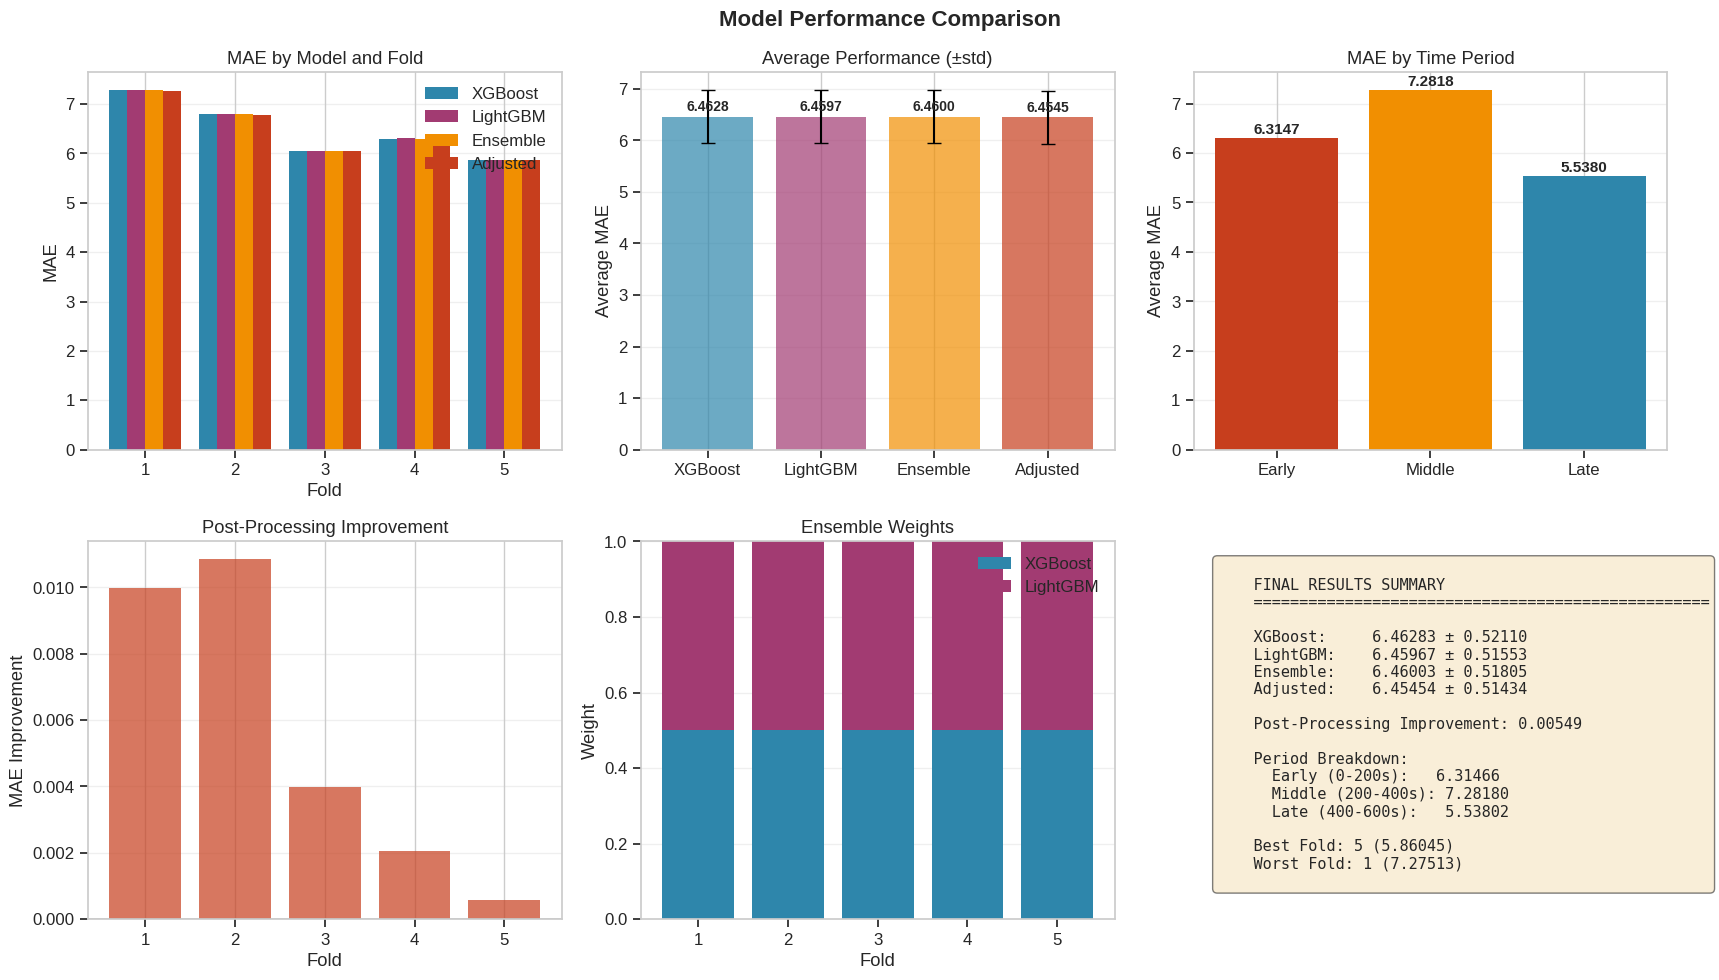

In [25]:
plot_model_comparison(fold_results)


In [26]:
def plot_detailed_fold_analysis(fold_results, stock_profiles, fold_idx=-1):
    """Detailed analysis for a specific fold."""
    results = fold_results[fold_idx]
    val_df = results['val_df']
    y_true = results['y_val'].values
    preds = results['adjusted_preds']
    errors = np.abs(y_true - preds)
    
    fig, axes = plt.subplots(3, 4, figsize=(24, 16))
    actual_fold = len(fold_results) if fold_idx == -1 else fold_idx + 1
    fig.suptitle(f'Fold {actual_fold} Detailed Analysis', fontsize=16, fontweight='bold')
    
    # 1. Predictions vs Actual
    ax = axes[0, 0]
    sample_idx = np.random.choice(len(y_true), min(5000, len(y_true)), replace=False)
    ax.scatter(y_true[sample_idx], preds[sample_idx], alpha=0.3, s=10, c=COLORS['primary'])
    lims = [min(y_true.min(), preds.min()), max(y_true.max(), preds.max())]
    ax.plot(lims, lims, 'r--', linewidth=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Predictions vs Actual')
    
    # 2. Error distribution
    ax = axes[0, 1]
    ax.hist(errors, bins=100, color=COLORS['primary'], alpha=0.7)
    ax.axvline(x=np.median(errors), color='red', linestyle='--', label=f'Median: {np.median(errors):.2f}')
    ax.axvline(x=np.mean(errors), color='green', linestyle='--', label=f'Mean: {np.mean(errors):.2f}')
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title('Error Distribution')
    ax.legend()
    
    # 3. MAE by time
    ax = axes[0, 2]
    time_mae = []
    time_labels = []
    for t in range(0, 600, 10):
        mask = (val_df['seconds_in_bucket'] >= t) & (val_df['seconds_in_bucket'] < t + 10)
        if mask.sum() > 0:
            time_mae.append(mean_absolute_error(y_true[mask], preds[mask]))
            time_labels.append(t)
    
    ax.plot(time_labels, time_mae, color=COLORS['primary'], linewidth=2)
    ax.axvspan(200, 400, alpha=0.2, color='red', label='Middle Period')
    ax.set_xlabel('Seconds in Bucket')
    ax.set_ylabel('MAE')
    ax.set_title('MAE Throughout Auction')
    ax.legend()
    
    # 4. Residuals by predicted value
    ax = axes[0, 3]
    residuals = y_true - preds
    ax.scatter(preds[sample_idx], residuals[sample_idx], alpha=0.3, s=10, c=COLORS['secondary'])
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Residual')
    ax.set_title('Residuals vs Predictions')
    
    # 5. MAE by stock cluster
    ax = axes[1, 0]
    val_df_copy = val_df.copy()
    val_df_copy['error'] = errors
    val_df_copy['cluster'] = val_df_copy['stock_id'].map(stock_profiles['cluster'].to_dict())
    cluster_mae = val_df_copy.groupby('cluster')['error'].mean().sort_values(ascending=False)
    
    colors_cluster = plt.cm.tab20(np.linspace(0, 1, len(cluster_mae)))
    ax.barh(range(len(cluster_mae)), cluster_mae.values, color=colors_cluster)
    ax.set_yticks(range(len(cluster_mae)))
    ax.set_yticklabels([f'Cluster {c}' for c in cluster_mae.index])
    ax.set_xlabel('MAE')
    ax.set_title('MAE by Stock Cluster')
    ax.invert_yaxis()
    
    # 6. Prediction distribution
    ax = axes[1, 1]
    ax.hist(y_true, bins=100, alpha=0.5, label='Actual', color=COLORS['primary'])
    ax.hist(preds, bins=100, alpha=0.5, label='Predicted', color=COLORS['accent'])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution Comparison')
    ax.legend()
    
    # 7. Zero-sum check
    ax = axes[1, 2]
    ts_means = val_df.copy()
    ts_means['pred'] = preds
    ts_means_grouped = ts_means.groupby(['date_id', 'seconds_in_bucket'])['pred'].mean()
    
    ax.hist(ts_means_grouped, bins=50, color=COLORS['secondary'], alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Mean Prediction per Timestamp')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Zero-Sum Check (std={ts_means_grouped.std():.4f})')
    
    # 8. Top 20 hardest stocks
    ax = axes[1, 3]
    stock_mae = val_df_copy.groupby('stock_id')['error'].mean().sort_values(ascending=False).head(20)
    ax.barh(range(len(stock_mae)), stock_mae.values, color=COLORS['success'])
    ax.set_yticks(range(len(stock_mae)))
    ax.set_yticklabels([f'Stock {s}' for s in stock_mae.index], fontsize=8)
    ax.set_xlabel('MAE')
    ax.set_title('Top 20 Hardest Stocks')
    ax.invert_yaxis()
    
    # 9. Feature importance (XGBoost)
    ax = axes[2, 0]
    importance = results['xgb_model'].feature_importances_
    features = results['xgb_model'].feature_names_in_
    top_idx = np.argsort(importance)[-15:]
    
    ax.barh(range(15), importance[top_idx], color=COLORS['primary'])
    ax.set_yticks(range(15))
    ax.set_yticklabels(features[top_idx], fontsize=8)
    ax.set_xlabel('Importance')
    ax.set_title('Top 15 Features (XGBoost)')
    
    # 10. Feature importance (LightGBM)
    ax = axes[2, 1]
    importance = results['lgb_model'].feature_importances_
    features = results['lgb_model'].feature_name_
    top_idx = np.argsort(importance)[-15:]
    
    ax.barh(range(15), importance[top_idx], color=COLORS['secondary'])
    ax.set_yticks(range(15))
    ax.set_yticklabels([features[i] for i in top_idx], fontsize=8)
    ax.set_xlabel('Importance')
    ax.set_title('Top 15 Features (LightGBM)')
    
    # 11. MAE by lead vs non-lead
    ax = axes[2, 2]
    val_df_copy['is_lead'] = val_df_copy['stock_id'].isin(LEAD_STOCKS)
    lead_mae = val_df_copy[val_df_copy['is_lead']]['error'].mean()
    nonlead_mae = val_df_copy[~val_df_copy['is_lead']]['error'].mean()
    
    ax.bar(['Lead Stocks', 'Other Stocks'], [lead_mae, nonlead_mae], 
           color=[COLORS['accent'], COLORS['primary']], alpha=0.7)
    ax.set_ylabel('MAE')
    ax.set_title('Lead vs Non-Lead Stocks')
    for i, mae in enumerate([lead_mae, nonlead_mae]):
        ax.text(i, mae + 0.02, f'{mae:.4f}', ha='center', fontsize=11, fontweight='bold')
    
    # 12. Statistics summary
    ax = axes[2, 3]
    ax.axis('off')
    
    summary = f"""
    FOLD {actual_fold} STATISTICS
    {'='*40}
    
    Sample Size: {len(y_true):,}
    
    MAE Scores:
      XGBoost:   {results['xgb_mae']:.5f}
      LightGBM:  {results['lgb_mae']:.5f}
      Ensemble:  {results['ensemble_mae']:.5f}
      Adjusted:  {results['adjusted_mae']:.5f}
    
    Prediction Range:
      Actual: [{y_true.min():.1f}, {y_true.max():.1f}]
      Pred:   [{preds.min():.1f}, {preds.max():.1f}]
    
    Error Statistics:
      Mean:   {errors.mean():.4f}
      Median: {np.median(errors):.4f}
      Max:    {errors.max():.2f}
    
    Coverage:
      ±5 bps:  {(errors <= 5).mean():.1%}
      ±10 bps: {(errors <= 10).mean():.1%}
    """
    ax.text(0.05, 0.95, summary, fontsize=10, family='monospace',
            verticalalignment='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


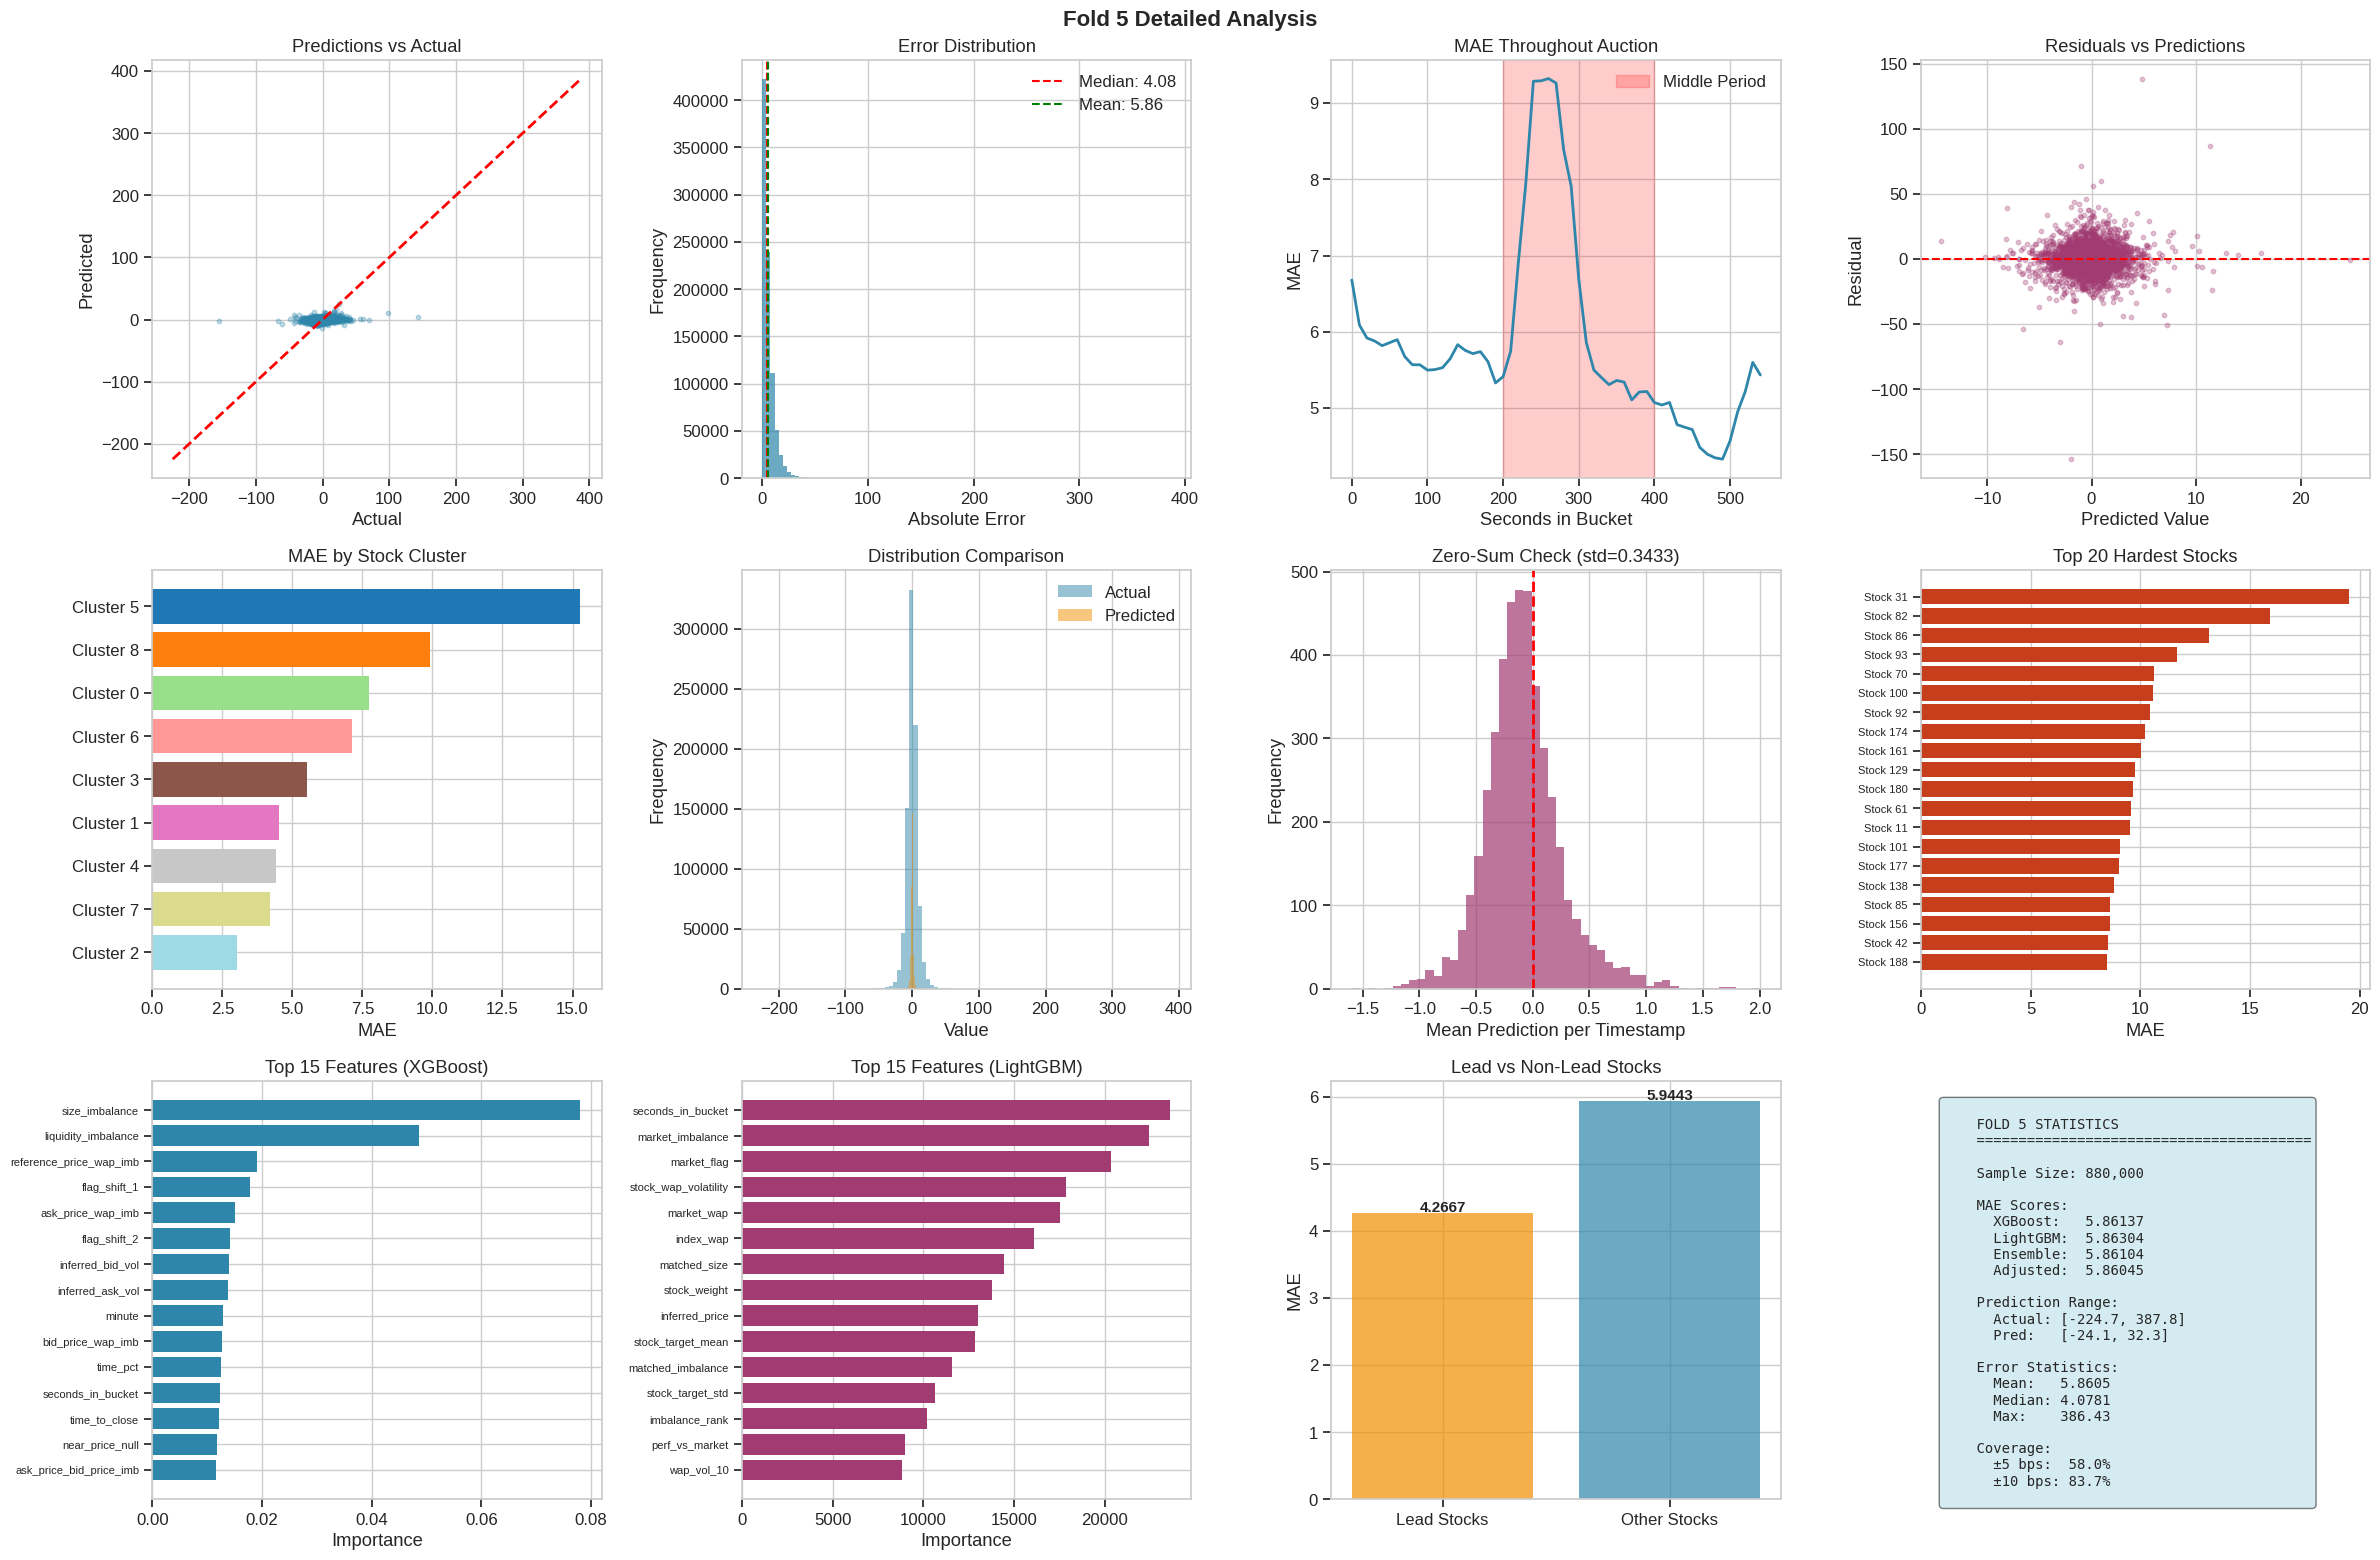

In [27]:
# Plot detailed analysis for last fold
plot_detailed_fold_analysis(fold_results, stock_profiles, fold_idx=-1)


In [28]:
def print_final_summary(fold_results):
    """Print final summary of results."""
    print("="*70)
    print("FINAL CROSS-VALIDATION RESULTS")
    print("="*70)
    
    xgb_maes = [r['xgb_mae'] for r in fold_results]
    lgb_maes = [r['lgb_mae'] for r in fold_results]
    ens_maes = [r['ensemble_mae'] for r in fold_results]
    adj_maes = [r['adjusted_mae'] for r in fold_results]
    
    print(f"\n{'Model':<15} {'Mean MAE':<12} {'Std':<10} {'Best':<10} {'Worst':<10}")
    print("-"*60)
    print(f"{'XGBoost':<15} {np.mean(xgb_maes):<12.5f} {np.std(xgb_maes):<10.5f} {min(xgb_maes):<10.5f} {max(xgb_maes):<10.5f}")
    print(f"{'LightGBM':<15} {np.mean(lgb_maes):<12.5f} {np.std(lgb_maes):<10.5f} {min(lgb_maes):<10.5f} {max(lgb_maes):<10.5f}")
    print(f"{'Ensemble':<15} {np.mean(ens_maes):<12.5f} {np.std(ens_maes):<10.5f} {min(ens_maes):<10.5f} {max(ens_maes):<10.5f}")
    print(f"{'Adjusted':<15} {np.mean(adj_maes):<12.5f} {np.std(adj_maes):<10.5f} {min(adj_maes):<10.5f} {max(adj_maes):<10.5f}")
    
    print("\n" + "-"*60)
    print("PERIOD BREAKDOWN (Adjusted)")
    print("-"*60)
    for period in ['early', 'middle', 'late']:
        period_maes = [r[f'{period}_mae'] for r in fold_results]
        print(f"{period.capitalize():<10} {np.mean(period_maes):.5f} ± {np.std(period_maes):.5f}")
    
    print("\n" + "="*70)
    print("✅ Training Complete!")
    print("="*70)


In [29]:
print_final_summary(fold_results)


FINAL CROSS-VALIDATION RESULTS

Model           Mean MAE     Std        Best       Worst     
------------------------------------------------------------
XGBoost         6.46283      0.52110    5.86137    7.29226   
LightGBM        6.45967      0.51553    5.86304    7.28155   
Ensemble        6.46003      0.51805    5.86104    7.28511   
Adjusted        6.45454      0.51434    5.86045    7.27513   

------------------------------------------------------------
PERIOD BREAKDOWN (Adjusted)
------------------------------------------------------------
Early      6.31466 ± 0.52286
Middle     7.28180 ± 0.54601
Late       5.53802 ± 0.50005

✅ Training Complete!
